---
title: Solving the Gierer-Meinhardt model using Julia
subtitle: Learning how to discretize and solve a reaction-diffusion system in Julia
summary: Learning how to discretize and solve a reaction-diffusion system in Julia
authors:
- admin
tags: ['Partial Differential Equations', 'Dynamical Systems', 'Julia', 'Coding']
categories: []
date: "2023-08-31T00:00:00Z"
lastMod: "2023-08-31T00:00:00Z"
featured: false
draft: false

# Featured image
# To use, add an image named `featured.jpg/png` to your page's folder. 
image:
  caption: ""
  focal_point: ""

# Projects (optional).
#   Associate this post with one or more of your projects.
#   Simply enter your project's folder or file name without extension.
#   E.g. `projects = ["internal-project"]` references 
#   `content/project/deep-learning/index.md`.
#   Otherwise, set `projects = []`.
projects: []
---

## Solving the Gierer-Meinhardt model using Julia
The Gierer-Meinhardt model is defined as follows: 

$$ \frac{\partial u}{\partial t} = D_u \Delta u +  \rho\frac{u^2}{v} - \mu_u u + \rho_u $$

$$ \frac{\partial v}{\partial t} =  D_v \Delta v + \rho u^2 - \mu_v v + \rho_v \, ,$$

with 

- $u$ being a short-range autocatalytic substance, or in other words, an activator,
- $v$ being its long-range antagonist, or in other words, an inhibitor, and,
- $\Delta = \sum\limits_{i = 1}^{n} \frac{\partial^2}{\partial x_i^2}$ being the n-dimensional Laplace operator.

In the Gierer-Meinhardt equations, the autocatalytic substance activates both itself and the inhibitor substance (with rate $\rho u^2)$, whereas the inhibitor substance inhibits the growth of the autocatalytic substance (with rate $\frac{1}{v})$. Both substances have a natural decay rate of the form $\mu_u u$ and $\mu_v v$ respectively. Finally, both substances have an activator-independent production rate ($\rho_u$ and $\rho_v$).

For the right choice of parameters, pattern formation can be observed in the solution of the Gierer-Meinhardt model.

More info on the Gierer-Meinhardt model can be found in [this](http://www.scholarpedia.org/article/Gierer-Meinhardt_model) scholarpedia article.  

## Solving the system
We'll solve the following IBVP:

$$ \frac{\partial u}{\partial t} = D_u \Delta u +  \rho\frac{u^2}{v} - \mu_u u + \rho_u $$

$$ \frac{\partial v}{\partial t} =  D_v \Delta v + \rho u^2 - \mu_v v + \rho_v \; $$

$$ u(x,y,0) = \exp{\left(-(x-a)^2-(y-a)^2\right)}, \quad \forall (x,y) \in (0,L)^2$$
$$ v(x,y,0) = {\rm rand}(), \quad \forall (x,y) \in (0,L)^2$$
$$ \frac{\partial u}{\partial n}(x,0,t)  = \frac{\partial v}{\partial n}(x,0,t) = 0, \quad \forall x \in [0,L]$$
$$ \frac{\partial u}{\partial n}(x,L,t)  = \frac{\partial v}{\partial n}(x,L,t) = 0, \quad \forall x \in [0,L]$$
$$ \frac{\partial u}{\partial n}(0,y,t)  = \frac{\partial v}{\partial n}(0,y,t) = 0, \quad \forall y \in [0,L]$$
$$ \frac{\partial u}{\partial n}(L,y,t)  = \frac{\partial v}{\partial n}(L,y,t) = 0, \quad \forall y \in [0,L] \;.$$



We start by initializing the parameters

In [1]:
Du = 1;
Dv = 100;

ρ_u = 0.5;
ρ_v = 0;
ρ = 1;
μ_u = 1;
μ_v = 6.1;

a = 5;

L = 100;

Then, we discretize the 2D space grid

In [4]:
sizez = L;  # size of the 2D grid
dx = 100.0 / sizez;  # space step

and then we discretize time

In [5]:
T = 150.0;  # total time
dt = 0.0003;  # time step
n = floor(Int, (T / dt));  # number of iterations

nvis = 500; # saves every nvis time steps

Next we use a random seed in order for the results to be the same across multiple runs and set the initial conditions

In [6]:
using Random
Random.seed!(1)
U = [exp(-(x-a)^2-(y-a)^2) for x in 1:1:sizez, y in 1:1:sizez];
V = rand(sizez, sizez);

Consequently, we initialize two matrices for the inside of the grid, and five matrices that will help us compute the Laplacian

In [7]:
Uc = zeros(Float64, sizez - 2, sizez - 2);
Vc = copy(Uc);
Ztop = copy(Uc);
Zleft = copy(Uc);
Zbottom = copy(Uc);
Zright = copy(Uc);
Zcenter = copy(Uc);

Finally, we initialize a 3D matrix, in order to save $u$ every $nvis$ time steps

In [8]:
UR = zeros(sizez, sizez, floor(Int, n/nvis));

We define a function in order to discretize the Laplacian, using the broadcasting abilities of Julia and the `@views` macro.

In [9]:
@views function DLaplacian(Z) # Centered differences discretization of the Laplacian
    Ztop .= Z[1:end-2, 2:end-1]
    Zleft .= Z[2:end-1, 1:end-2]
    Zbottom .= Z[3:end, 2:end-1]
    Zright .= Z[2:end-1, 3:end]
    Zcenter .= Z[2:end-1, 2:end-1]
    return (Ztop .+ Zleft .+ Zbottom .+ Zright .- 4 .* Zcenter) ./ (dx^2)
end

DLaplacian (generic function with 1 method)

We then proceed to iterate the solution beginning from the second timestep and ending in timestep $n$.

In [10]:
@views begin
    j = 1
    for i in 2:n
        Uc .= U[2:end-1, 2:end-1]
        Vc .= V[2:end-1, 2:end-1]
    
        U[2:end-1, 2:end-1] .= Uc .+ dt .* (Du .* DLaplacian(U) .+ ρ_u .- μ_u .* Uc .+ ρ.* (Uc.^2)./Vc )
        V[2:end-1, 2:end-1] .= Vc .+ dt .* (Dv .* DLaplacian(V) .+ ρ_v .- μ_v .* Vc .+ ρ.* Uc.^2 )
    
        for Z in (U, V)  # Neumann boundary conditions
            Z[1, :] .= Z[2, :]
            Z[end, :] .= Z[end-1, :]
            Z[:, 1] .= Z[:, 2]
            Z[:, end] .= Z[:, end-1]
        end

        if i%nvis == 0
            UR[:,:,j] .= U
            j += 1
        end
    end
end

We notice interesting spot-like patterns in the solution for $t = 1000 \cdot dt \cdot nvis$

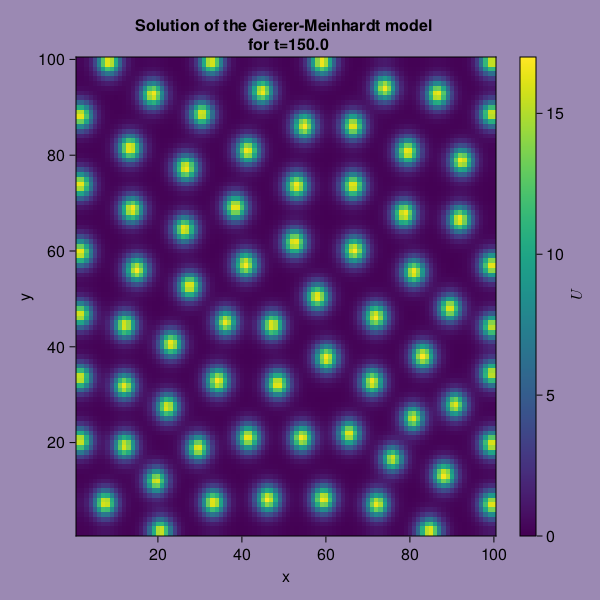

In [24]:
using CairoMakie

joint_limits = (0, 17)

time_step = 1000
time = time_step * dt * nvis

fig = Figure(backgroundcolor = "#9B89B3",
             resolution = (600, 600))
ax = Axis(fig[1,1],
          title = "Solution of the Gierer-Meinhardt model \n for t=$(time)",
          xlabel = "x",
          ylabel = "y")
hmr = CairoMakie.heatmap!(ax, UR[:,:,time_step])
Colorbar(fig[:,end+1], colorrange = joint_limits, label = L"U")
fig

Of course, if we want to speed things up, we'll want to wrap the above code in a function

In [1]:
using Random

@views function GiererMeinhardt() 
    Du = 1;
    Dv = 100;
    
    ρ_u = 0.5;
    ρ_v = 0;
    ρ = 1;
    μ_u = 1;
    μ_v = 6.1;
    
    a = 5;
    
    L = 100;

    nvis = 1000
    
    sizez = 100  # size of the 2D grid
    dx = 100.0 / sizez  # space step
    
    T = 150.0  # total time
    dt = 0.0003  # time step
    n = floor(Int, (T / dt))  # number of iterations
    
    Uc = zeros(Float64, sizez - 2, sizez - 2)
    Vc = copy(Uc)
    Ztop = copy(Uc)
    Zleft = copy(Uc)
    Zbottom = copy(Uc)
    Zright = copy(Uc)
    Zcenter = copy(Uc)

    Random.seed!(1)
    U = [exp(-(x-a)^2-(y-a)^2) for x in 1:1:sizez, y in 1:1:sizez]
    V = fill(1.0, sizez, sizez)

    UR = zeros(sizez, sizez, floor(Int, n/nvis))
    
    function DLaplacian(Z) # Centered differences discretization of the Laplacian
        Ztop .= Z[1:end-2, 2:end-1]
        Zleft .= Z[2:end-1, 1:end-2]
        Zbottom .= Z[3:end, 2:end-1]
        Zright .= Z[2:end-1, 3:end]
        Zcenter .= Z[2:end-1, 2:end-1]
        return (Ztop .+ Zleft .+ Zbottom .+ Zright .- 4 .* Zcenter) ./ (dx^2)
    end
    
    j = 1
    for i in 2:n
        Uc .= U[2:end-1, 2:end-1]
        Vc .= V[2:end-1, 2:end-1]
    
        U[2:end-1, 2:end-1] .= Uc .+ dt .* (Du .* DLaplacian(U) .+ ρ_u .- μ_u .* Uc .+ ρ.* (Uc.^2)./Vc )
        V[2:end-1, 2:end-1] .= Vc .+ dt .* (Dv .* DLaplacian(V) .+ ρ_v .- μ_v .* Vc .+ ρ.* Uc.^2 )
    
        for Z in (U, V)
            Z[1, :] .= Z[2, :]
            Z[end, :] .= Z[end-1, :]
            Z[:, 1] .= Z[:, 2]
            Z[:, end] .= Z[:, end-1]
        end

        if i%nvis == 0
            UR[:,:,j] .= U
            j += 1
        end
    end
    return UR
end

resG = GiererMeinhardt();

Finally, we make a nice little video illustrating how the pattern formed

In [2]:
using CairoMakie

joint_limits = (0, 17)

fig = Figure(backgroundcolor = "#9B89B3",
             resolution = (600, 600))
ax = Axis(fig[1,1],
          title = "Solution of the Gierer-Meinhardt model",
          xlabel = "x",
          ylabel = "y")
hmr = CairoMakie.heatmap!(ax, resG[:,:,1])
Colorbar(fig[:,end+1], colorrange = joint_limits, label = L"U")
fig

nframes = 10
framerate = 30
iterator = 1:2:500

record(fig, "GiererMeinhardt.mp4", iterator;
        framerate = framerate) do t
    CairoMakie.heatmap!(ax, resG[:,:,t], colorrange = joint_limits)
end

"GiererMeinhardt.mp4"

Of course, different initial conditions and parameter values, will change the behavior of the model. So, [download](./index.ipynb) the notebook and do some experimenting!